TO DO:

Last changes:
# histogram of time cycles
# PCA, Screeplot and loadings  -> select 
# plot of settings and sensor measurements: using floating window approach to flatten noise -> 
# 

In [5]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [6]:
# define header
header_txt = ["unit_number","time_cycle", "setting_1", "setting_2", "setting_3",
              "sensor_1", "sensor_2", "sensor_3","sensor_4","sensor_5","sensor_6", "sensor_7", "sensor_8", "sensor_9", 
              "sensor_10", "sensor_11", "sensor_12", "sensor_13", "sensor_14", "sensor_15", "sensor_16", "sensor_17", 
              "sensor_18", "sensor_19", "sensor_20", "sensor_21"] 

## Import data

train_FD001

In [7]:
## import FD001 & remove empty columns

df_train_FD001 = pd.read_csv("../CMAPSSdata/train_FD001.txt", sep=" ", header = None)
df_train_FD001=df_train_FD001.drop([26,27], axis=1)
df_train_FD001.name = "train_FD001"

In [8]:
df_train_FD001.columns = header_txt # add header to datafile

# df_train_FD001 = df_train_FD001.groupby("unit_number").apply(lambda x: x.assign(RUL = x["time_cycle"].max() - x["time_cycle"])) #https://medium.com/@dreamferus/predictive-maintenance-in-python-exploratory-analysis-and-visualization-de363d5a39de 
print("The data set train_FD001 has", df_train_FD001.shape[0],"rows and",df_train_FD001.shape[1], "columns.")
no_units_train_FD001 = max(df_train_FD001["unit_number"]);
print("The data set train_FD001 has",no_units_train_FD001 ,"test observations / units." )

df_train_FD001.head()

The data set train_FD001 has 20631 rows and 26 columns.
The data set train_FD001 has 100 test observations / units.


,unit_number,time_cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


unit_number
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: time_cycle, Length: 100, dtype: int64


Text(0, 0.5, 'number of units')

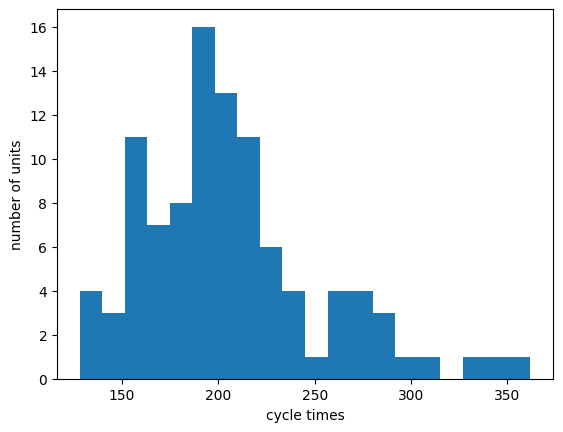

In [9]:
# print cycle time to failure max_time_cycles
curr_dataSet = df_train_FD001
max_time_cycle = curr_dataSet.groupby("unit_number")["time_cycle"].max() #  cycle times per unit
print(max_time_cycle)

# show histogram of max_time_cycles
plt.hist(max_time_cycle, bins=20)
plt.xlabel("cycle times")
plt.ylabel("number of units")


## Functions

Check Outlier

In [10]:
#curr_dataSet = df_train_FD001

def checkOutlier(curr_dataSet):
    no_rows =curr_dataSet.count(axis=0)
    if len(no_rows[no_rows != len(curr_dataSet)]) > 0: 
        print("ATTENTION: Inconsistent number of rows:\n", no_rows[no_rows != len(curr_dataSet)] )
    else :
        print("All columns have same length.")
    
    if curr_dataSet.isnull().values.any(): #ckeck missing values
        print("ATTENTION: Some values might be missing.")
    else:
        print("No missing values (isnull) detected!")

#checkOutlier(df_train_FD001)


In [11]:
checkOutlier(df_train_FD001)

All columns have same length.
No missing values (isnull) detected!


Non changing signals

In [12]:
def checkStdCloseZero(curr_dataSet):# No changing signals - std = 0 
    # for opperating settings -> no influence for RUL
    print("Standard deviation close to zero for " ,curr_dataSet.columns[np.isclose(curr_dataSet.std(axis=0), 0, rtol=1e-05, atol=1e-08, equal_nan=False)].values)
    #print("Sensor singals with std equals null:", curr_dataSet.columns[curr_dataSet.std(axis=0) == 0])

#checkStdCloseZero(df_train_FD001)


In [13]:
checkStdCloseZero(df_train_FD001)

Standard deviation close to zero for  ['setting_3' 'sensor_1' 'sensor_5' 'sensor_10' 'sensor_16' 'sensor_18'
 'sensor_19']


Visualization of operating settings

In [14]:
def plotSettings(curr_dataSet, unitNumber):
    for i in range(1,4):
        plt.figure(i)
        plt.xlabel("time_cycle")
        plt.ylabel("operation setting %.f" %i)
        #plt.title('Operation Setting %.f' %i)
        
        for j in unitNumber: # unit
            plt.plot(curr_dataSet[curr_dataSet["unit_number"]==j]["time_cycle"],curr_dataSet[curr_dataSet["unit_number"]==j]["setting_"+str(i)].rolling(window=30).mean(), label = j)
        plt.legend()

#change: rolling average to smoothing        
#df.rolling(window=30).mean()    quelle: https://medium.com/@dreamferus/predictive-maintenance-in-python-exploratory-analysis-and-visualization-de363d5a39de
#visOpSet(df_train_FD001,[1,2,3,4,5])

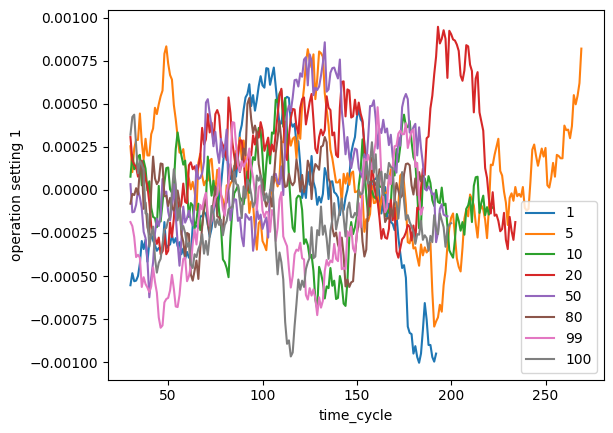

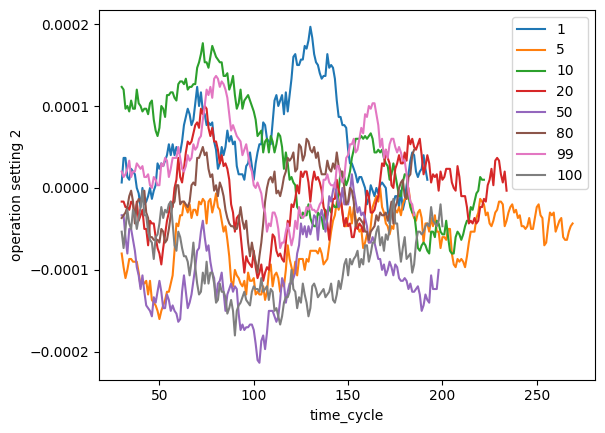

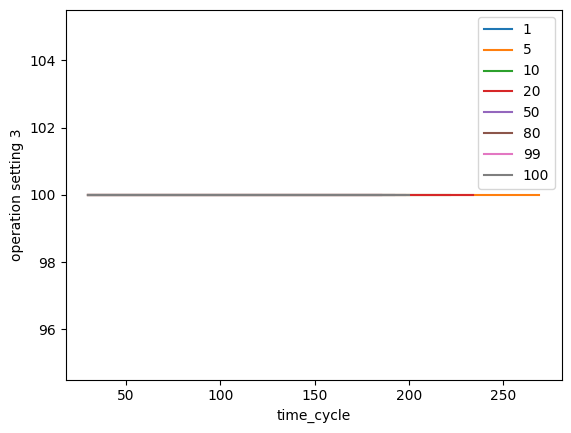

In [15]:
plotSettings(df_train_FD001,unitNumber=[1,5,10,20,50,80,99,100])

Visualization of measurement signals

In [16]:
# plot measurement singals for sensor number [s1, s2, ...] and unit (array) of data_Set
def plotSensor(curr_dataSet,sensorID, unitNumber):
    for i in sensorID: # number of sensor
        plt.figure(i)
        plt.ylabel("sensor measurement %.f" %i)
        plt.xlabel("time")
        for j in unitNumber: # unit
            plt.plot(curr_dataSet[curr_dataSet["unit_number"]==j]["time_cycle"], curr_dataSet[curr_dataSet["unit_number"]==j]["sensor_"+str(i)], label=j)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)
        #plt.ylim(min(curr_dataSet[curr_dataSet["unit_number"]==j]["sensor_"+str(i)]), max(curr_dataSet[curr_dataSet["unit_number"]==j]["sensor_"+str(i)]))

#visMeasure(df_train_FD001)

C:\Users\johan\AppData\Local\Temp\ipykernel_21044\1758369304.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i)


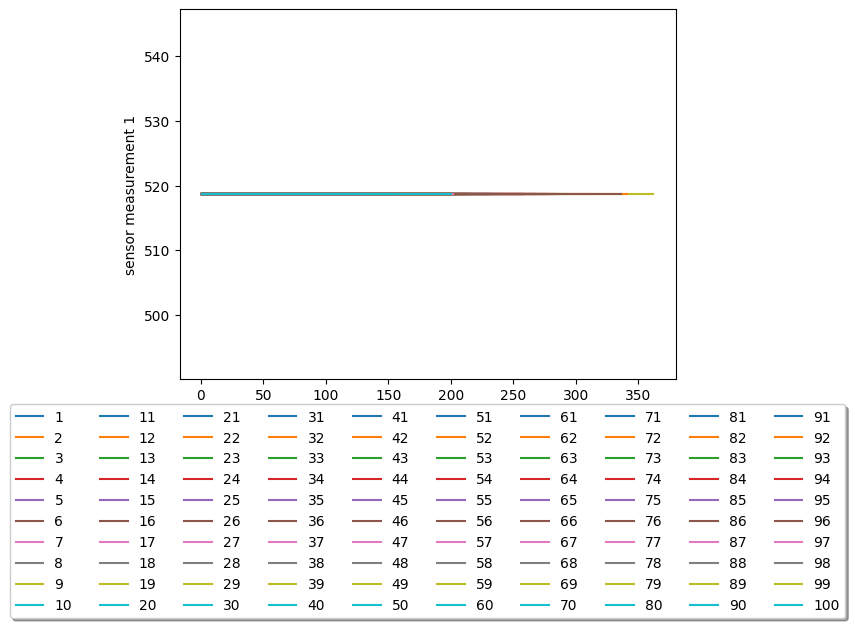

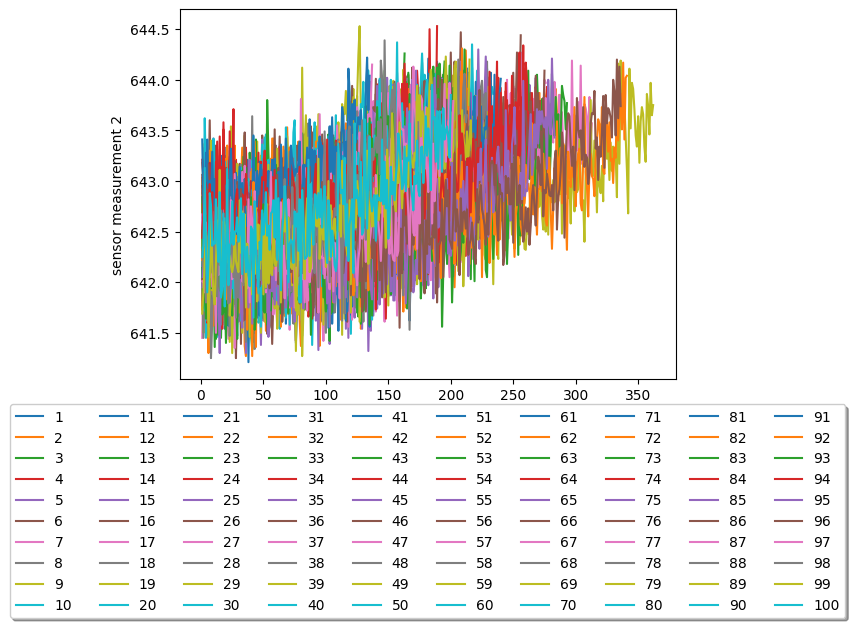

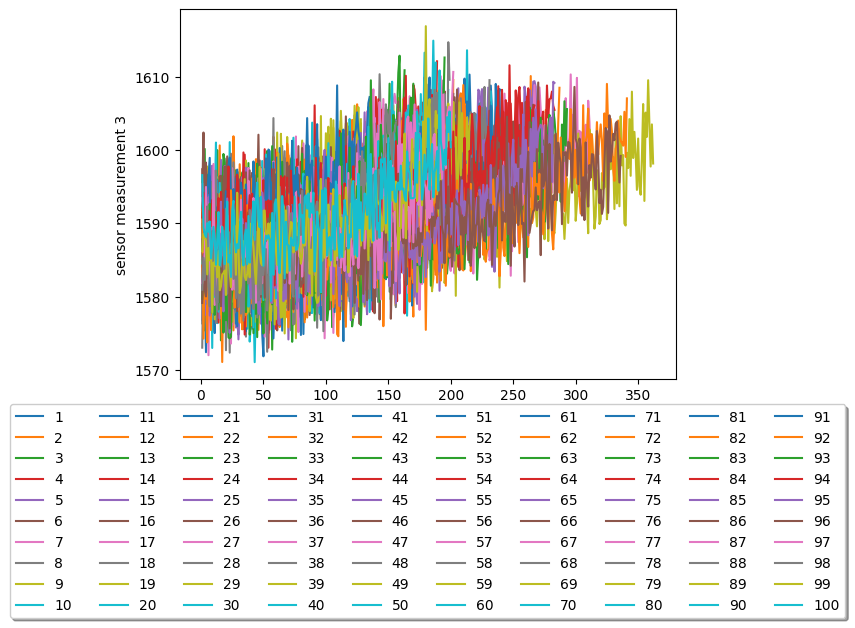

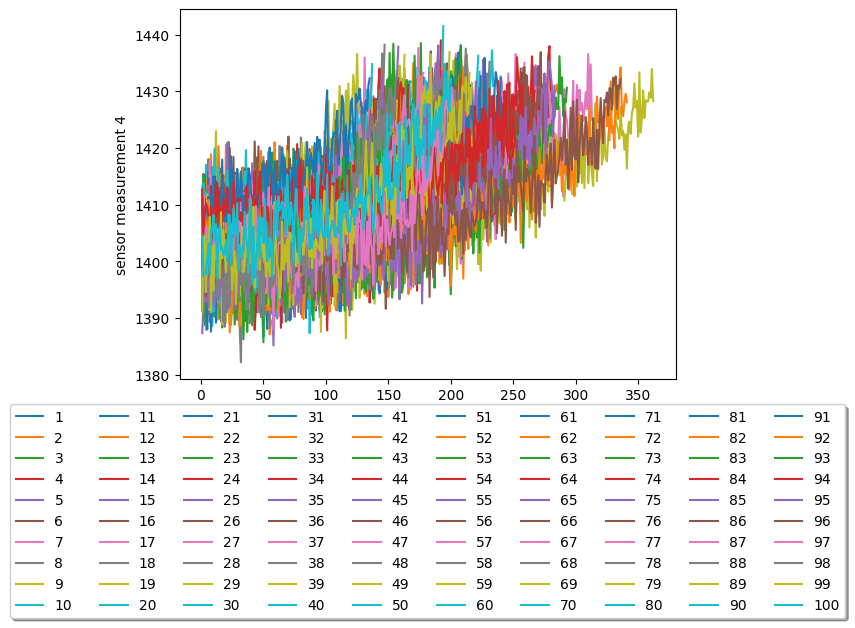

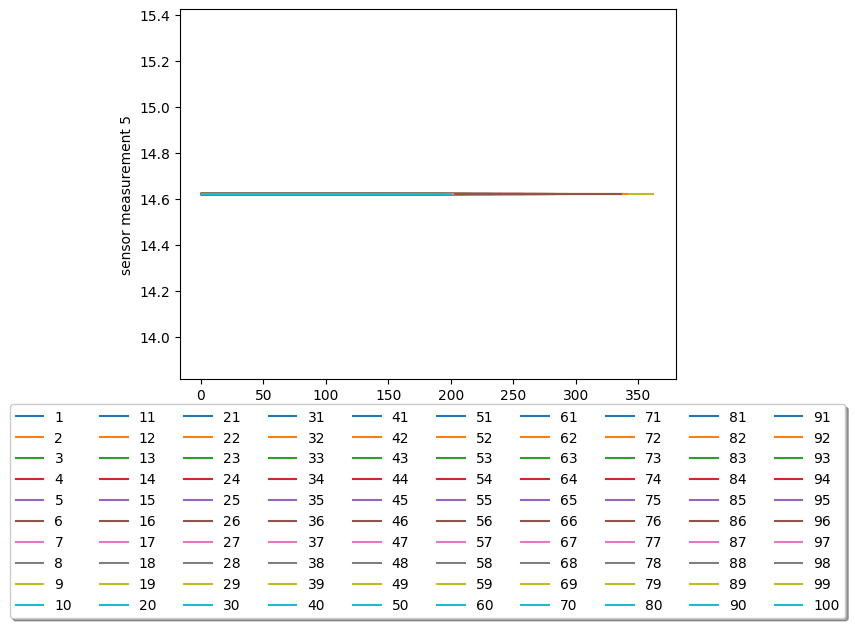

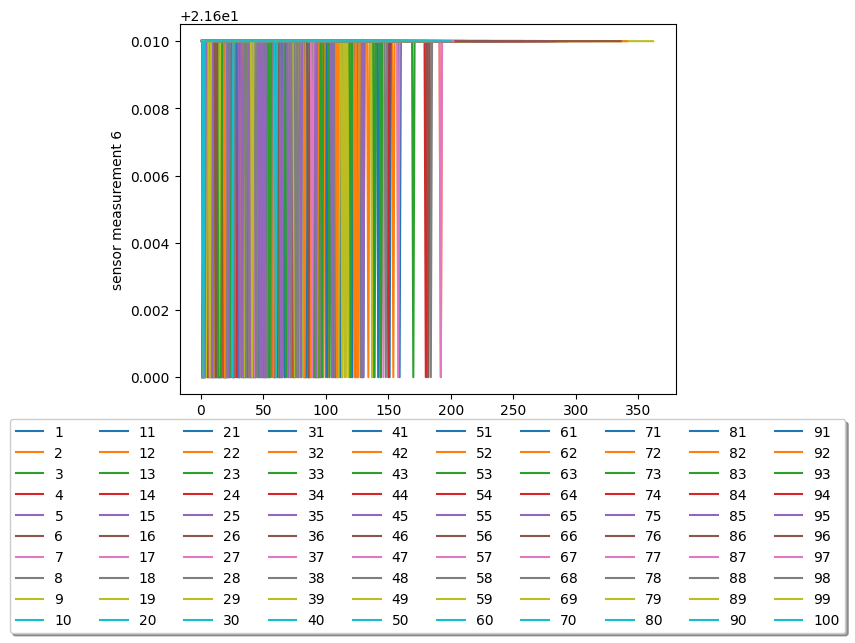

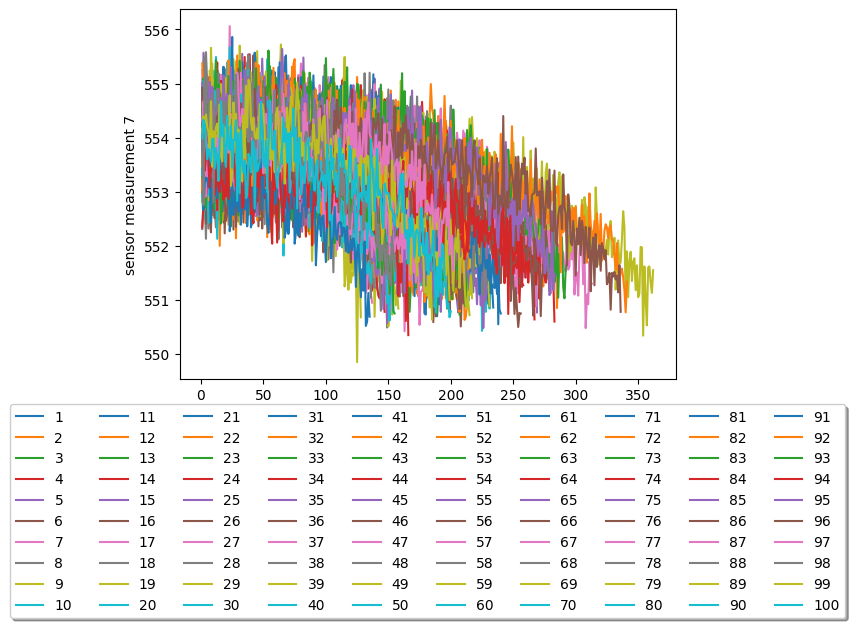

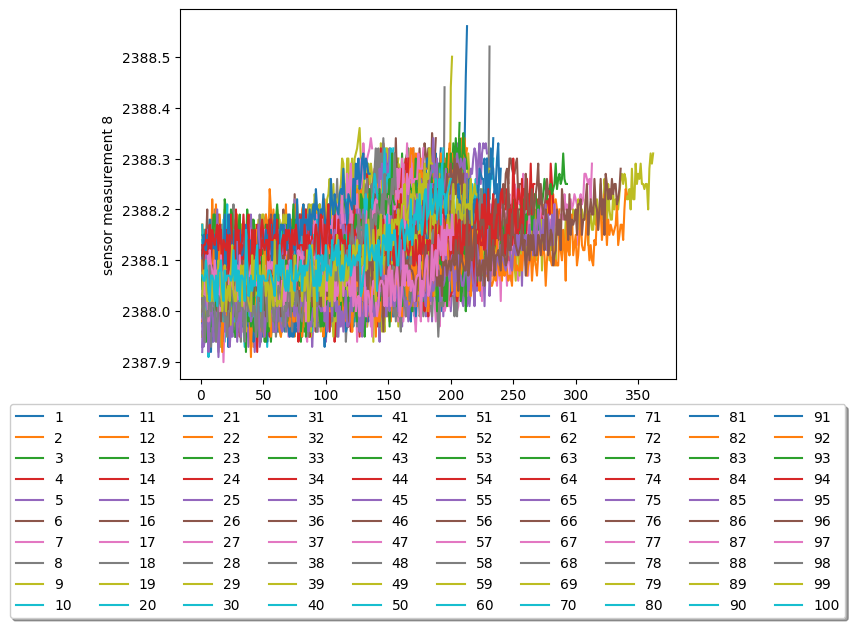

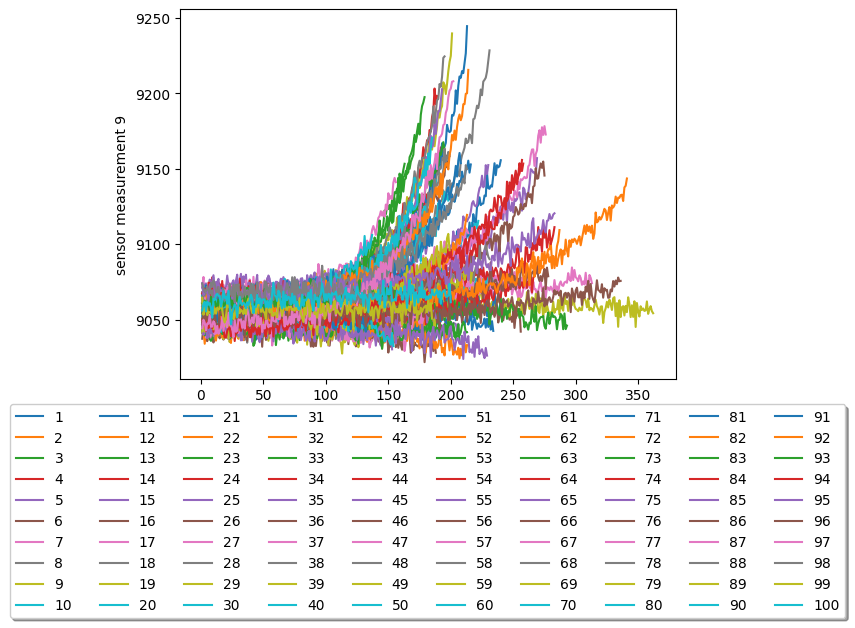

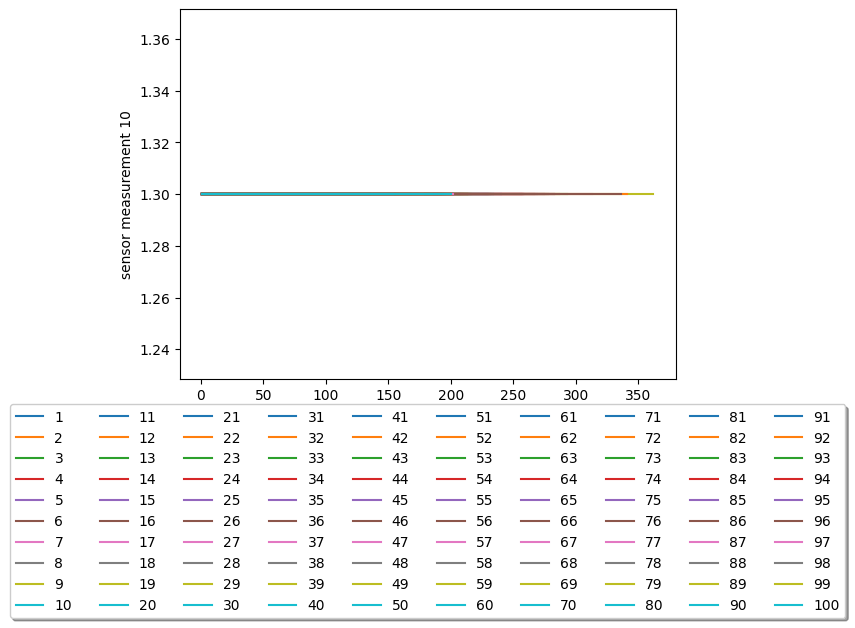

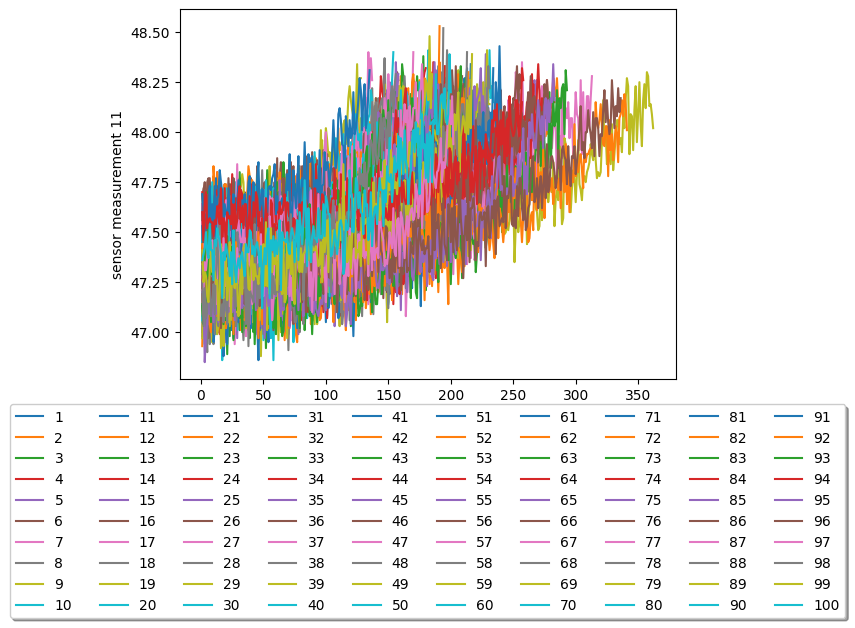

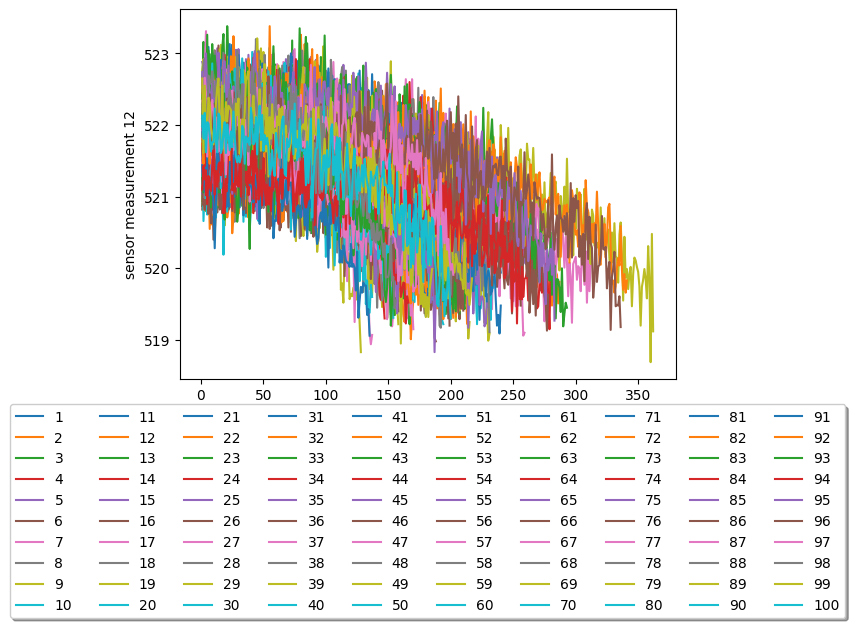

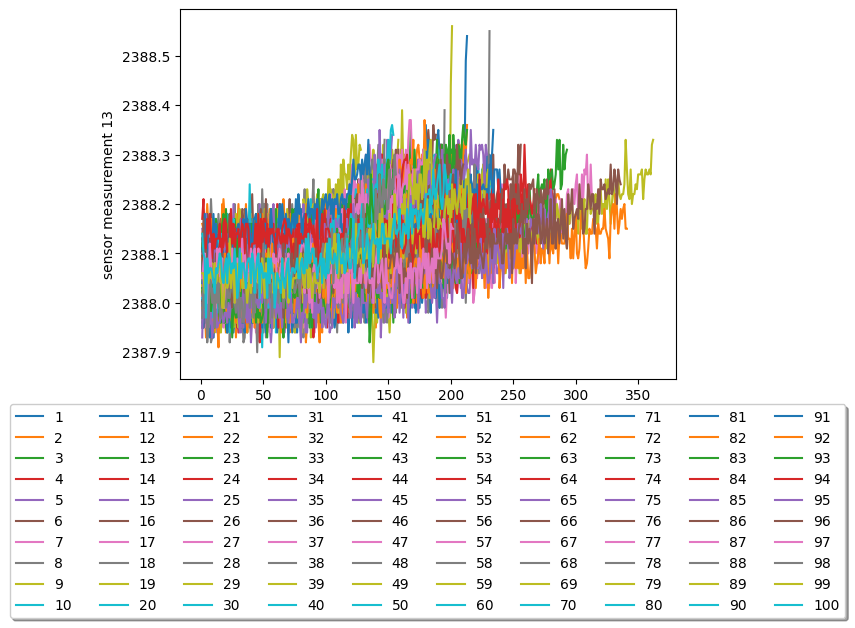

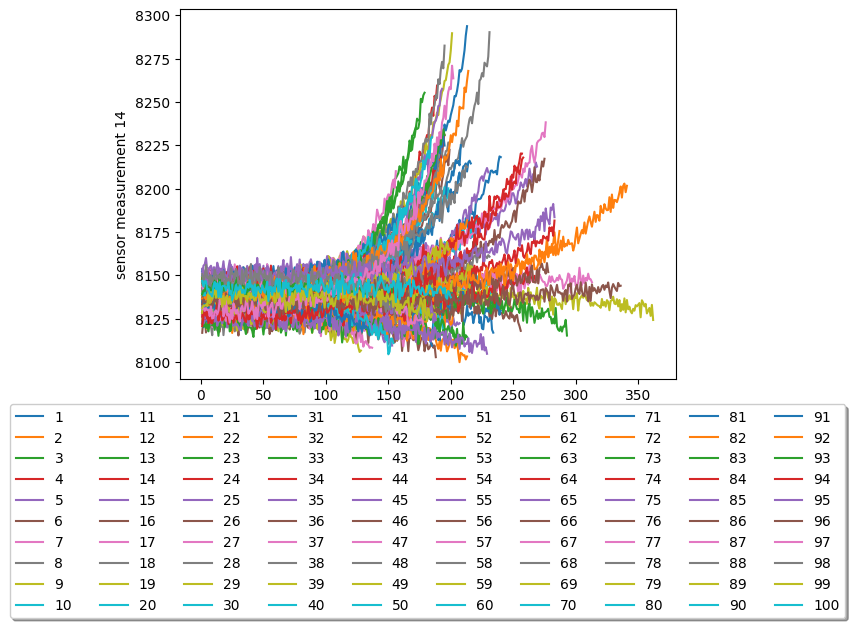

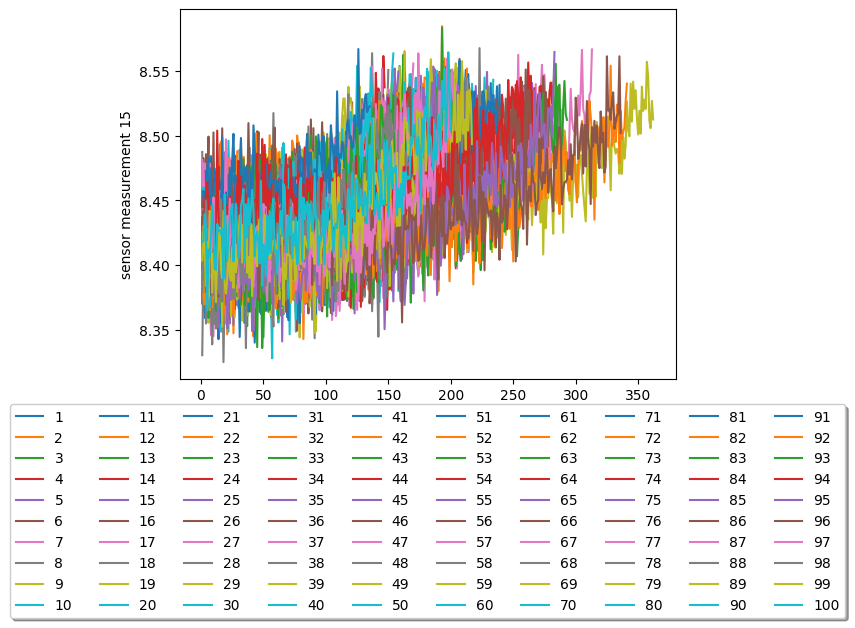

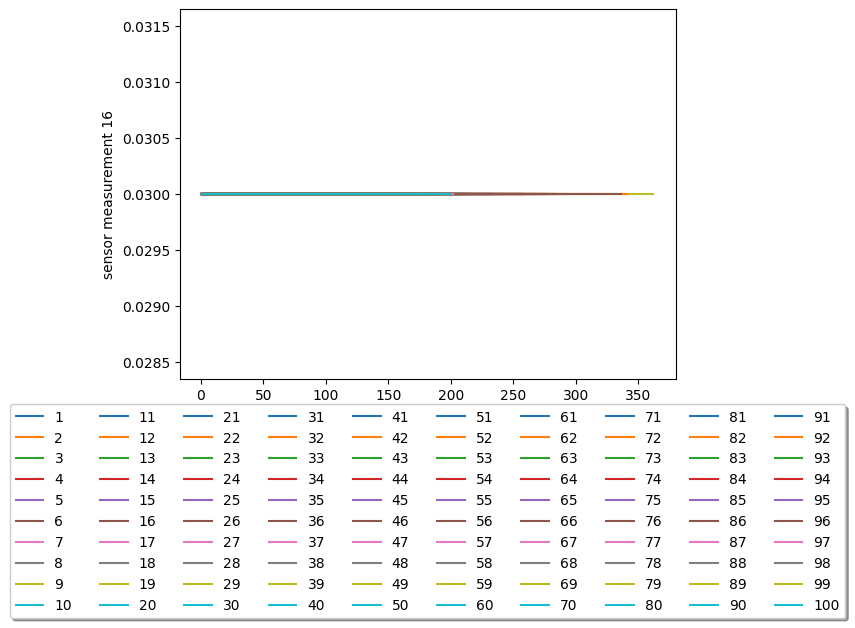

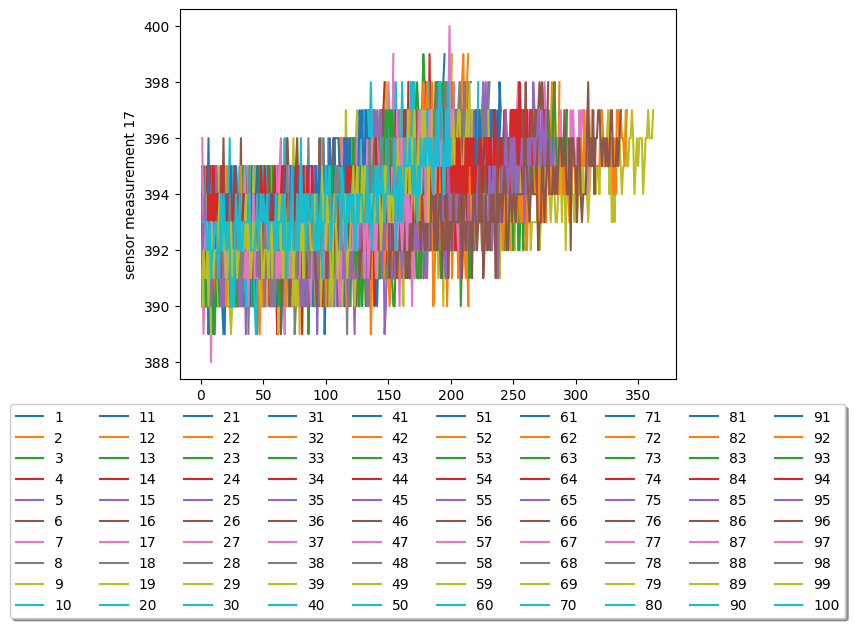

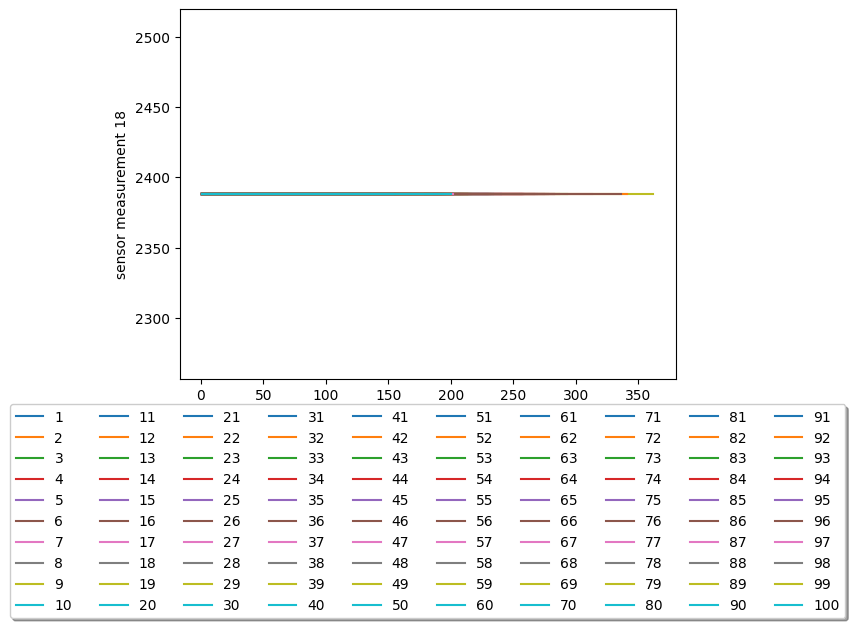

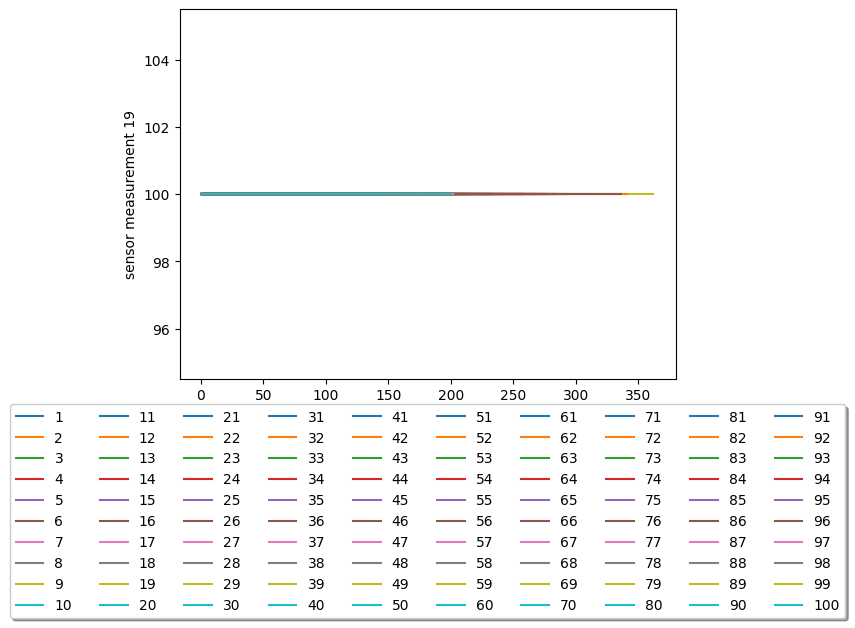

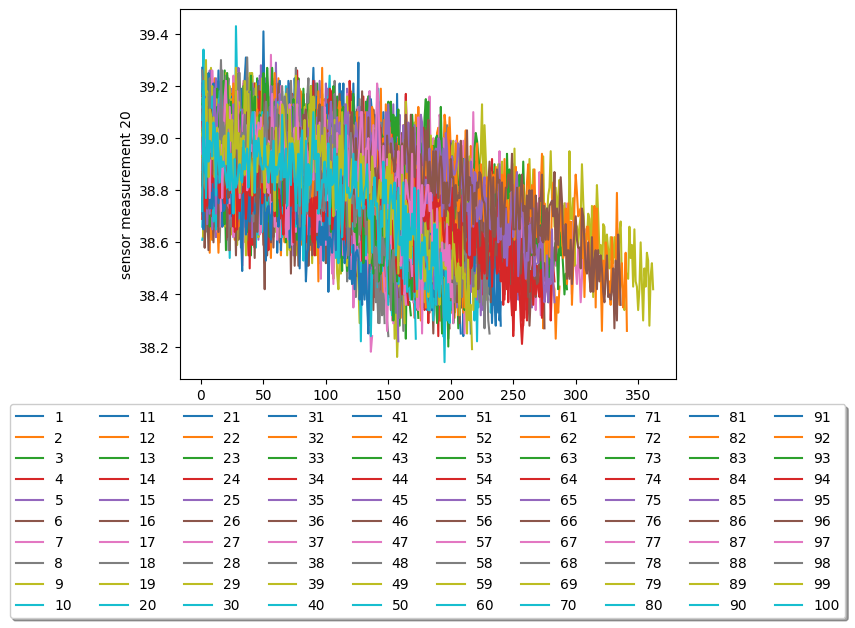

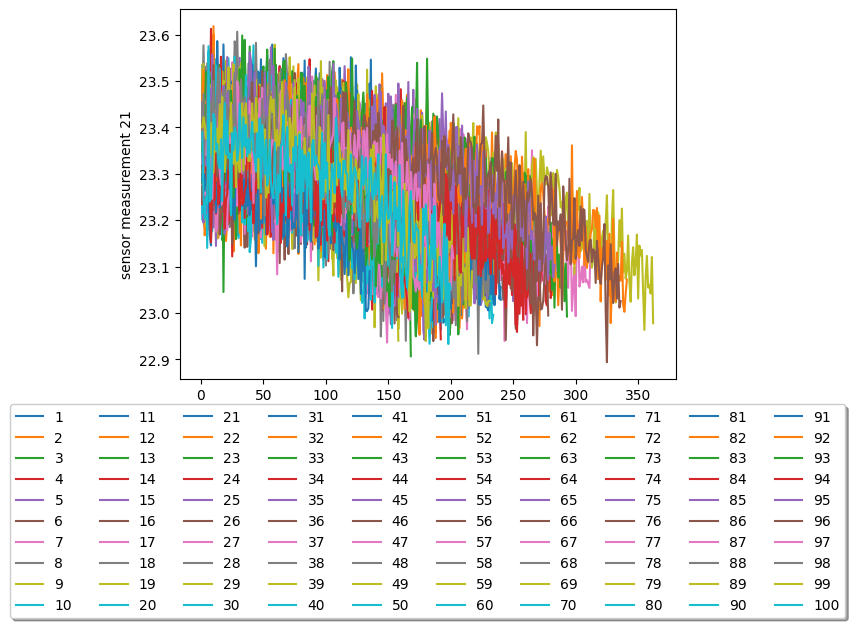

In [17]:
plotSensor(df_train_FD001, sensorID=range(1,22), unitNumber=range(1,101)) 


In [18]:
# Plot correlation matrix of "sensor measurements" 
# input: curr_dataSet = FD00x; unitNumber = 1-xxx

def mapSensorCorr(curr_dataSet,unitNumber):
    # https://thomas-berweger.medium.com/sdfsdf-3678cd946bd0
    plt.figure
    sns.heatmap(curr_dataSet[curr_dataSet["unit_number"]==unitNumber].iloc[:,5:].corr(), cmap='coolwarm', linecolor='white',linewidths=1, annot=True)
    plt.title("Correlation of Signal Measurements "+str(curr_dataSet.name)+ " unit "+str(unitNumber))
    plt.show()



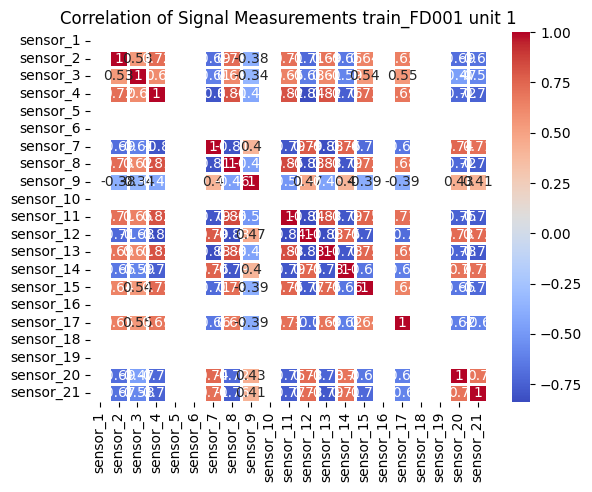

In [19]:
mapSensorCorr(df_train_FD001,1)


In [20]:
# https://stackoverflow.com/questions/39409866/correlation-heatmap
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

def mapSensorCorr2(curr_dataSet,unitNumber):
     cmap = sns.diverging_palette(5, 250, as_cmap=True)
     corr = curr_dataSet[curr_dataSet["unit_number"]==unitNumber].iloc[:,5:].corr()
     return corr.style.background_gradient(cmap, axis=1)\
     .format(precision=3)\
     .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
     .set_caption("Correlation of "+ str(curr_dataSet.name)+ "\n unit"+str(unitNumber))\
     .set_table_styles(magnify())
     


In [21]:
mapSensorCorr2(df_train_FD001,1)

c:\Users\johan\miniconda3\envs\aiinpe\Lib\site-packages\pandas\io\formats\style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\johan\miniconda3\envs\aiinpe\Lib\site-packages\pandas\io\formats\style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
sensor_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_2,nan,1.000,0.534,0.715,nan,nan,-0.689,0.725,-0.379,nan,0.709,-0.709,0.693,-0.650,0.637,nan,0.648,nan,nan,-0.689,-0.675
sensor_3,nan,0.534,1.000,0.600,nan,nan,-0.612,0.618,-0.342,nan,0.646,-0.631,0.613,-0.593,0.545,nan,0.546,nan,nan,-0.471,-0.584
sensor_4,nan,0.715,0.600,1.000,nan,nan,-0.799,0.815,-0.426,nan,0.817,-0.838,0.819,-0.757,0.728,nan,0.691,nan,nan,-0.722,-0.745
sensor_5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_7,nan,-0.689,-0.612,-0.799,nan,nan,1.000,-0.809,0.402,nan,-0.793,0.787,-0.829,0.759,-0.705,nan,-0.656,nan,nan,0.745,0.709
sensor_8,nan,0.725,0.618,0.815,nan,nan,-0.809,1.000,-0.459,nan,0.849,-0.827,0.826,-0.789,0.717,nan,0.684,nan,nan,-0.716,-0.761
sensor_9,nan,-0.379,-0.342,-0.426,nan,nan,0.402,-0.459,1.000,nan,-0.506,0.467,-0.446,0.400,-0.390,nan,-0.393,nan,nan,0.434,0.409
sensor_10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## PCA
Preform PCA and generate Screeplot

In [22]:
# Compute 
# quelle https://statologie.de/scree-diagramm-python/

unit_number = 1
curr_dataSet = df_train_FD001
scaler = StandardScaler()
# Standardise data (copy)
scaled_df = curr_dataSet[curr_dataSet["unit_number"]==1].iloc[:,[1,2,3,6,7,8,10,11,12,13,14,16,19,20]].copy() # work with copy of data set
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)

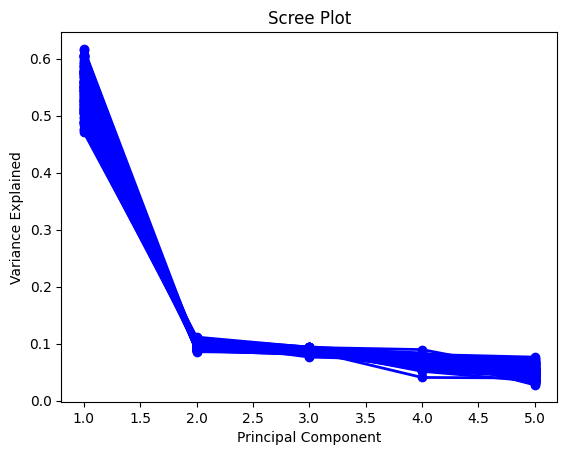

In [23]:

PC_values = []

plt.figure()
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
expl_variance_ratio_over_units = []
loadings = np.zeros((14,5))

i = 1
for i in range(1,101): # unit_number
    scaled_df = curr_dataSet[curr_dataSet["unit_number"]==i].iloc[:,[1,2,3,6,7,8,10,11,12,13,14,16,19,20]].copy()
    scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
    pca = PCA(n_components=5)
    pca_fit = pca.fit(scaled_df)
    PC_values = (np.arange(pca.n_components_) + 1)
    plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
    expl_variance_ratio_over_units.append(pca.explained_variance_ratio_)
    curr_loadings = (pca.components_.T * np.sqrt(pca.explained_variance_))>0.5 # check if loading is high, then add +1 to loadings array
    loadings = loadings + curr_loadings.astype(int)


In [24]:
# generate loadings matrix: matrix show number of units that have a high loading (~ correlation) (loading > 0.5) on the respective principal component PCi
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2','PC3', 'PC4','PC5'], 
                              index=["sensor_2", "sensor_3","sensor_4", "sensor_7", "sensor_8",
              "sensor_9", "sensor_11", "sensor_12", "sensor_13", "sensor_14", "sensor_15", "sensor_17" ,"sensor_20", "sensor_21"])
print(loading_matrix) 

             PC1   PC2   PC3   PC4   PC5
sensor_2   100.0   0.0   0.0   0.0   0.0
sensor_3     0.0  36.0  19.0  22.0   1.0
sensor_4     0.0  34.0  27.0  16.0   1.0
sensor_7   100.0   0.0   0.0   2.0   9.0
sensor_8   100.0   0.0   0.0   2.0  21.0
sensor_9   100.0   0.0   0.0   0.0   0.0
sensor_11    0.0   0.0   0.0   0.0   0.0
sensor_12    0.0   0.0   0.0   0.0   0.0
sensor_13   91.0   1.0   1.0   3.0  10.0
sensor_14   61.0   3.0   2.0  15.0  15.0
sensor_15    0.0   0.0   0.0   0.0   0.0
sensor_17    0.0   0.0   0.0   0.0   0.0
sensor_20  100.0   0.0   0.0   0.0   2.0
sensor_21    0.0   0.0   0.0   0.0   0.0


In [25]:
#print(expl_variance_ratio_over_units)